In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

In [48]:
df = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-white.csv', sep=';')

# remove spaces from column names
df = df.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

# thankfully, no NA/missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


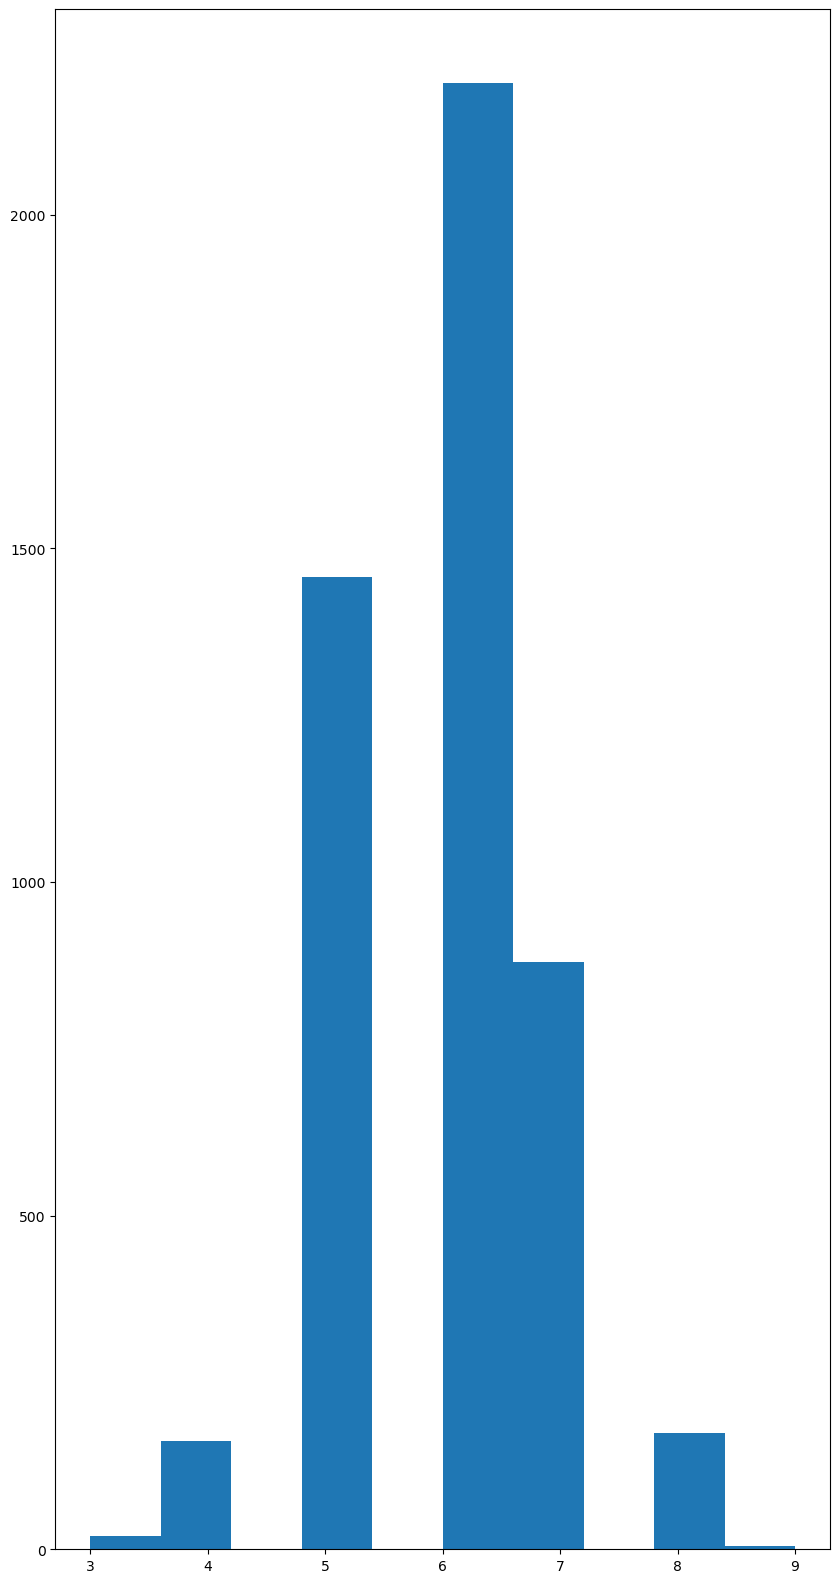

In [49]:
# exploring the ranges of the 'quality' values
df['quality'].hist(grid=False)
plt.show()

<AxesSubplot:>

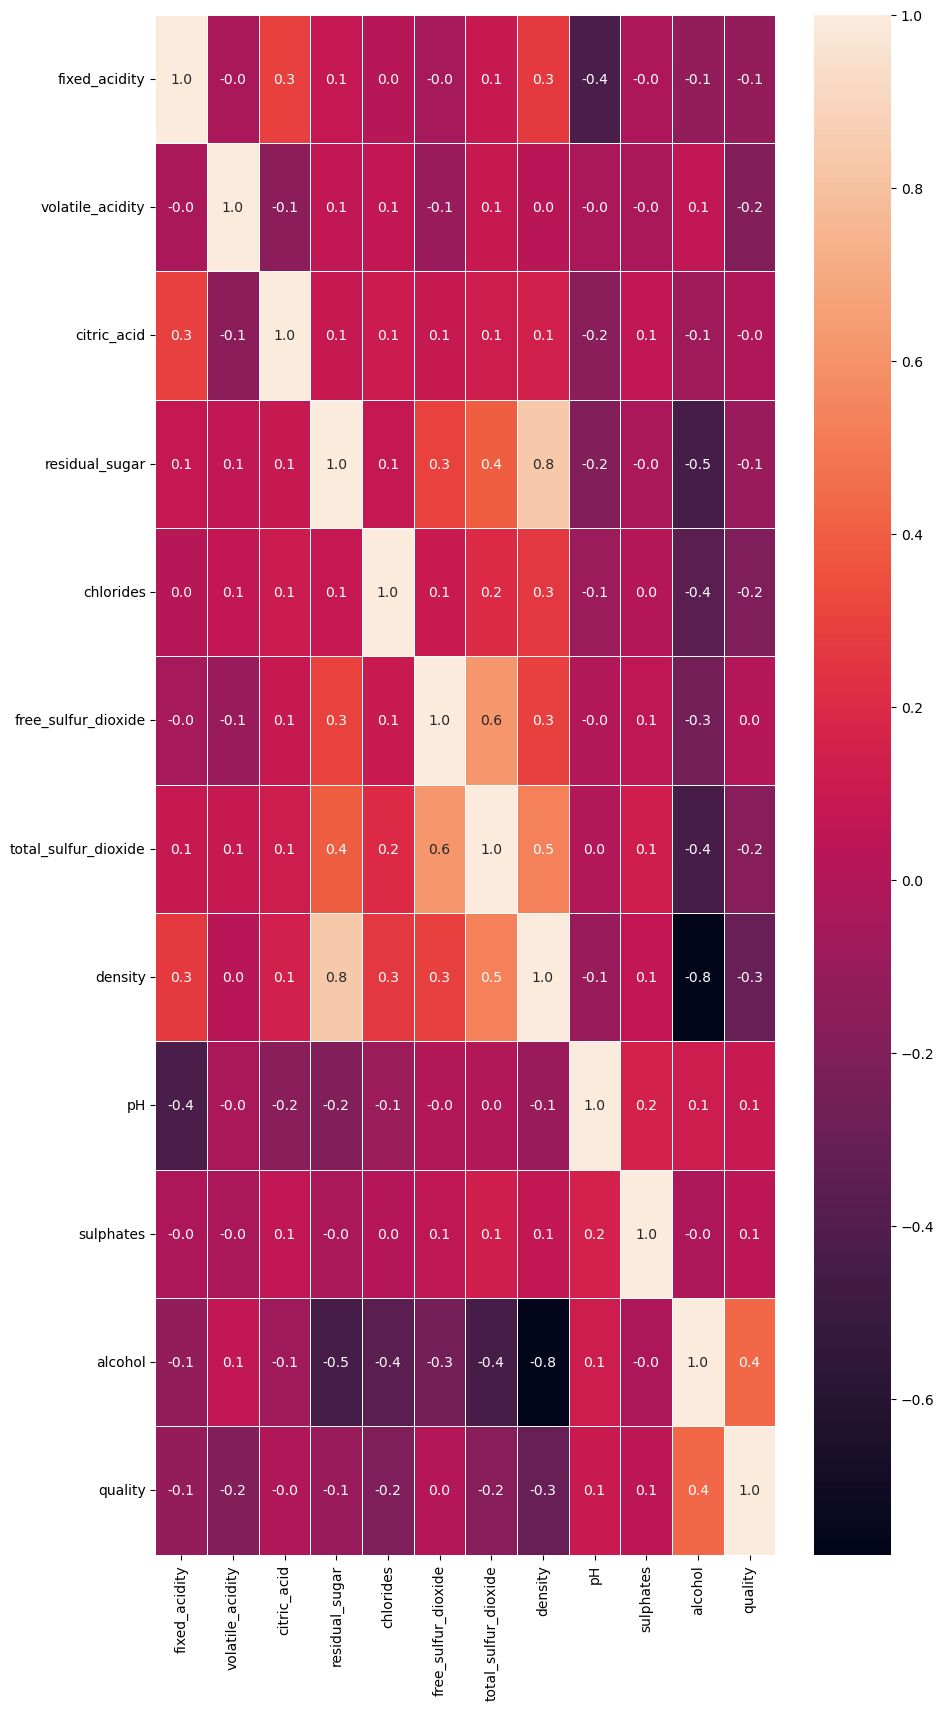

In [50]:
# exploring the corelation matrix
corr = df.corr()

# according to the heatmap, there are no good features 
# strongly correlated with the 'quality' score
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5)

In [51]:
# there is no strong correlation between 'quality' and any of the other columns

# get raw correlation values
# sort the matrix by lowest to highest values
corr_pairs = corr.unstack()
sorted_corr_pairs = corr_pairs.sort_values()
print(sorted_corr_pairs['quality'])

# according to the matrix, there are following interesting correlations:
#pos_corr = sorted_corr_pairs[(sorted_corr_pairs.values >= 0.5) & (sorted_corr_pairs.values < 1)]
#neg_corr = sorted_corr_pairs[(sorted_corr_pairs.values <= -0.5) & (sorted_corr_pairs.values > -1)]
#print(pos_corr)
#print(neg_corr)

# positive:
# residual sugar - density = 0.838966
# free sulfur dioxide - total sulfur dioxide = 0.615501
# density - total sulfur dioxide    0.529881
#
# negative:
# alcohol - density = -0.780138


density                -0.307123
chlorides              -0.209934
volatile_acidity       -0.194723
total_sulfur_dioxide   -0.174737
fixed_acidity          -0.113663
residual_sugar         -0.097577
citric_acid            -0.009209
free_sulfur_dioxide     0.008158
sulphates               0.053678
pH                      0.099427
alcohol                 0.435575
quality                 1.000000
dtype: float64


In [52]:
# first ill try to build a linear regression model to predict the raw 'quality' value

# create training and testing datasets
X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2)

# i will use all the available factors to find best possible for a linear regression
allowed_factors = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

best = ['',0]
for p in allowed_factors:
    model  = smf.ols(formula='quality ~ '+ p, data=X_train).fit()
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
print('best:',best)

# all models have poor R-squared score, so it doesnt seem like its possible to predict the score
# based only on one of the features

best: ['alcohol', 0.18886856581151157]


In [53]:
# next, i will try using all features to predict 'quality'
model  = smf.ols(formula='quality ~ ' + (' + ').join(allowed_factors), data=X_train).fit()
print(model.summary())

# this model performs slightly better than using just one of the features, but R-squared value is still very low
# and several of the features have very high p-values

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          6.16e-275
Time:                        21:55:12   Log-Likelihood:                -4400.9
No. Observations:                3918   AIC:                             8826.
Df Residuals:                    3906   BIC:                             8901.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              142.8098 

In [54]:
# lets try a model after removing the features with high p-values
model  = smf.ols(formula='quality ~ volatile_acidity + residual_sugar + free_sulfur_dioxide + density + pH + sulphates + alcohol', data=X_train).fit()
print(model.summary())

# but this model also has very low R-squared score, roughly the same as the model with all the features

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     220.9
Date:                Sun, 23 Apr 2023   Prob (F-statistic):          2.58e-277
Time:                        21:55:12   Log-Likelihood:                -4406.0
No. Observations:                3918   AIC:                             8828.
Df Residuals:                    3910   BIC:                             8878.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             111.8366    

In [55]:
# since i was not able to build a good linear regression model,
# i will instead attempt to build a classification model to predict the range of the scores

# to do this, i will create a new categorical column to simplify quality scoring
# i will add a new column 'score' to be a label of 'bad', 'ok', 'great'.
# based on 'quality' column ranges:
# bad: 3-4, ok: 5-6, great: 7-9
labels = ['bad', 'ok', 'great']
df['score'] = pd.cut(df['quality'], 3, right=False, labels=labels)

In [56]:
# there is a signigicant imbalance in "score" data, 
# majority of wines fall into "ok" category,
# and "bad" category has the smallest number of samples
bad = df[df['score'] == 'bad']
ok = df[df['score'] == 'ok']
great = df[df['score'] == 'great']

print('bad:', bad.count()['score'])
print('ok:', ok.count()['score'])
print('great:', great.count()['score'])

bad: 183
ok: 3655
great: 1060


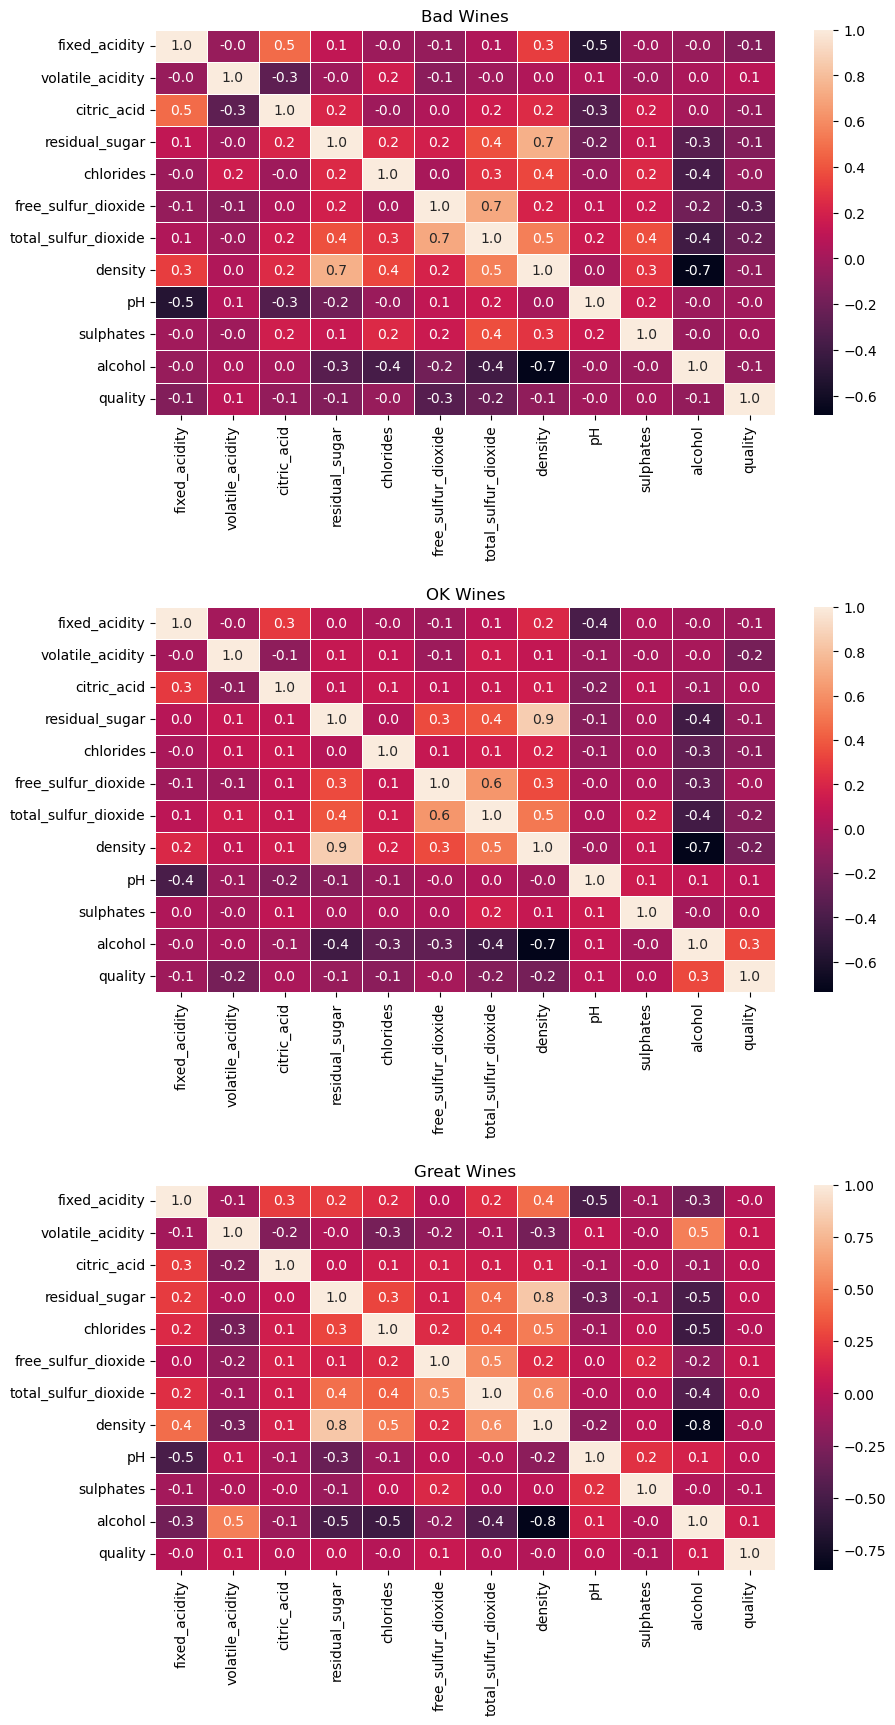

In [57]:
# next, ill explore any possible differences in correlations 
# within the 3 score categories

plt.rcParams["figure.figsize"] = [10, 20]
plt.rcParams["figure.autolayout"] = False

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=0.5)

ax1.set_title('Bad Wines')
ax2.set_title('OK Wines')
ax3.set_title('Great Wines')

sns.heatmap(bad.corr(), ax=ax1, annot=True, fmt=".1f", linewidth=.5)
sns.heatmap(ok.corr(), ax=ax2, annot=True, fmt=".1f", linewidth=.5)
sns.heatmap(great.corr(), ax=ax3, annot=True, fmt=".1f", linewidth=.5)

plt.show()

# none of the score groups show a significant correlation between 'quality' and any of the other features

In [58]:
# because of the significant 'score' class imbalance, 
# i will combine "bad" and "ok" into one class, and leave "great" as their own class
# then use the "ok" and "great" values as binary 0 and 1 to simplify classification
# and then attempt to build a classifier to predict a "great" wine
df['is_great'] = np.where(df['quality'] >= 7, 1, 0)
print(df['is_great'].value_counts())

0    3838
1    1060
Name: is_great, dtype: int64


In [59]:
# since there is still an imbalance, i will use undersampling to
# create a new dataset with equal number of "ok" and "great" wines
ok_count, great_count = df['is_great'].value_counts()

great = df[df['is_great'] == 1]
ok = df[df['is_great'] == 0]
ok_smaller = ok.sample(great_count)

# new dataset
balanced_data = pd.concat([ok_smaller, great], axis=0)

print('total dataset for analysis', balanced_data.shape)
print('ok wine:', balanced_data[balanced_data['is_great'] == 0].shape)
print('great wine:', balanced_data[balanced_data['is_great'] == 1].shape)

# now create the dataset for training and testing
X_train, X_test = train_test_split(balanced_data, train_size=0.8, test_size=0.2)
print('training:', X_train.shape, 'testing:', X_test.shape)

# split the dependent vars from independent
train_y = X_train['is_great'].values
train_X = X_train.drop(['is_great', 'score'], axis=1).values

test_y = X_test['is_great'].values
test_X = X_test.drop(['is_great', 'score'], axis=1).values

print('training y:', train_y.shape, 'training x:', train_X.shape)
print('testing y:', test_y.shape, 'testing x:', test_X.shape)

total dataset for analysis (2120, 14)
ok wine: (1060, 14)
great wine: (1060, 14)
training: (1696, 14) testing: (424, 14)
training y: (1696,) training x: (1696, 12)
testing y: (424,) testing x: (424, 12)


In [60]:
# set up metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_conf_mat(conf_matrix):
    plt.close()
    plt.clf()
    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    return plt

def plot_roc(roc_auc):
    plt.close()
    plt.clf()        
    plt.rcParams["figure.autolayout"] = False
    plt.figure(figsize=(3, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Great Wine ROC')
    plt.legend(loc="lower right")
    return plt
    
def run_metrics(test_y, yhat):
    # metrics
    print('precision:', precision_score(test_y, yhat))
    print('recall: ', recall_score(test_y, yhat))
    print('accuracy: ', accuracy_score(test_y, yhat))
    print(classification_report(test_y, yhat))

    # roc
    fpr, tpr, thresholds = roc_curve(test_y, yhat)
    roc_auc = auc(fpr, tpr)
    roc_plot = plot_roc(roc_auc)
    roc_plot.show()

    # confusion matrix
    conf_matrix = confusion_matrix(test_y, yhat)
    mat = plot_conf_mat(conf_matrix)
    mat.show()
    
    

precision: 0.6954545454545454
recall:  0.7391304347826086
accuracy:  0.714622641509434
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       217
           1       0.70      0.74      0.72       207

    accuracy                           0.71       424
   macro avg       0.72      0.72      0.71       424
weighted avg       0.72      0.71      0.71       424



<Figure size 1000x2000 with 0 Axes>

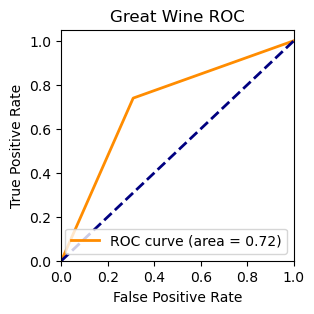

<Figure size 1000x2000 with 0 Axes>

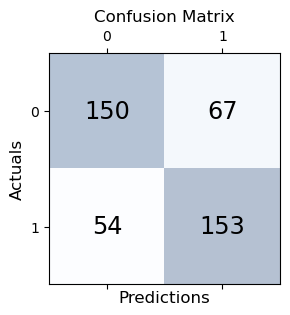

In [61]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

# metrics
print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()


precision: 0.7115384615384616
recall:  0.8604651162790697
accuracy:  0.7586206896551724
              precision    recall  f1-score   support

           0       0.83      0.66      0.73        44
           1       0.71      0.86      0.78        43

    accuracy                           0.76        87
   macro avg       0.77      0.76      0.76        87
weighted avg       0.77      0.76      0.76        87



<Figure size 1000x2000 with 0 Axes>

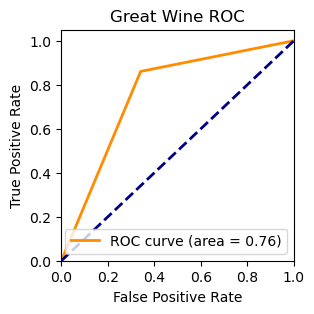

<Figure size 1000x2000 with 0 Axes>

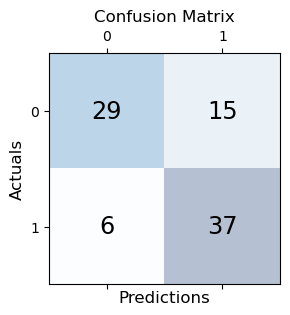

In [42]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 1.0
recall:  1.0
accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       207

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



<Figure size 1000x2000 with 0 Axes>

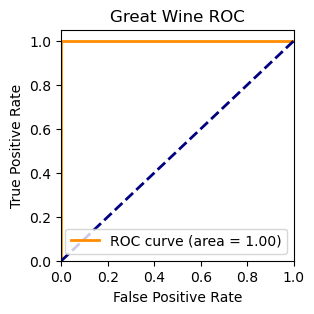

<Figure size 1000x2000 with 0 Axes>

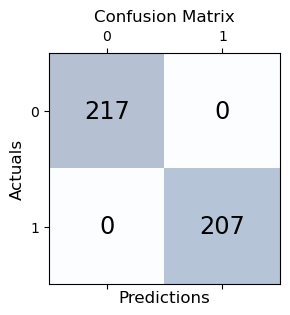

In [66]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 0.9333333333333333
recall:  0.27053140096618356
accuracy:  0.6344339622641509
              precision    recall  f1-score   support

           0       0.59      0.98      0.73       217
           1       0.93      0.27      0.42       207

    accuracy                           0.63       424
   macro avg       0.76      0.63      0.58       424
weighted avg       0.76      0.63      0.58       424



<Figure size 1000x2000 with 0 Axes>

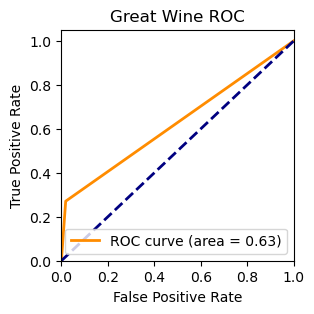

<Figure size 1000x2000 with 0 Axes>

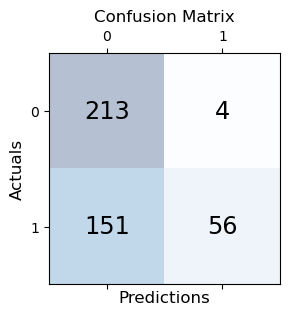

In [65]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

precision: 1.0
recall:  1.0
accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       207

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



<Figure size 1000x2000 with 0 Axes>

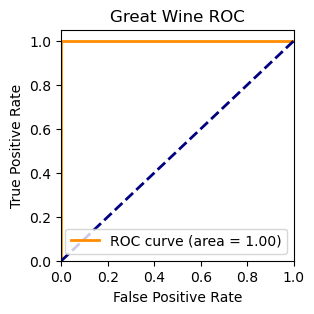

<Figure size 1000x2000 with 0 Axes>

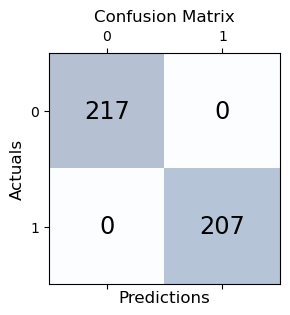

In [67]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

In [24]:
# todo: analyze decision tree splits
# todo: what did the paper say, what models and metrics they used, whats the EDA
# todo: gridsearch
# todo: more models on raw 'quality' score
# todo: what other interesting predictions besides 'quality' or 'score'
# DONE: maybe use both red and white datasets, and try to classify one vs the other?


precision: 1.0
recall:  1.0
accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       207

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



<Figure size 1000x2000 with 0 Axes>

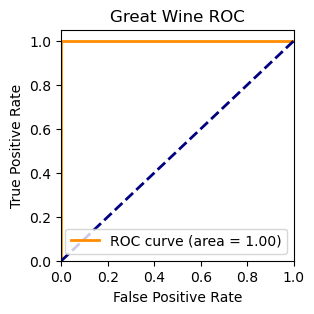

<Figure size 1000x2000 with 0 Axes>

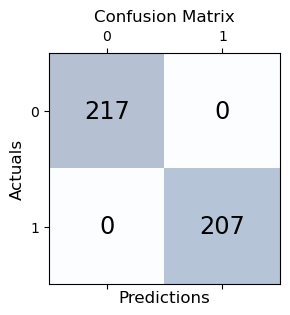

In [64]:
#from sklearn.ensemble import AdaBoostClassifier
#clf = AdaBoostClassifier()

#from sklearn.ensemble import BaggingClassifier
#clf = AdaBoostClassifier()

from sklearn.ensemble import GradientBoostingClassifier
clf = AdaBoostClassifier()

clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()

In [106]:
df_raw = df.drop(['quality', 'score'],axis=1)
df_raw.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_great
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.216415
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.411842
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,0.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


<AxesSubplot:>

<Figure size 1000x2000 with 0 Axes>

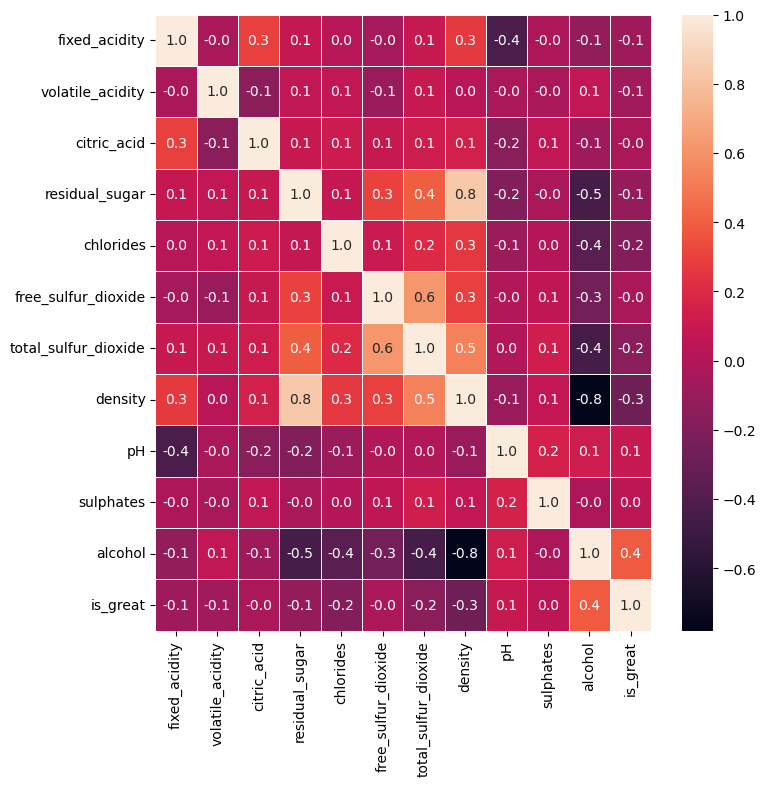

In [112]:
# testing correlation on scaled features

scaler = preprocessing.MinMaxScaler()
names = df_raw.columns
d = scaler.fit_transform(df_raw)

scaled_df_full = pd.DataFrame(d, columns=names)
#scaled_df_full.describe()

plt.close()
plt.clf()        
plt.rcParams["figure.autolayout"] = False
plt.figure(figsize=(8, 8))

corr = scaled_df_full.corr()
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5)

In [107]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()
features, labels=  oversample.fit_resample(df_raw.drop(["is_great"],axis=1), df_raw["is_great"])

scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)

scaled_df = pd.DataFrame(d, columns=names)
scaled_df.describe()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000
mean,0.289423,0.189179,0.199193,0.082239,0.101053,0.115033,0.289045,0.122436,0.434939,0.319390,0.455624
std,0.075133,0.092807,0.062868,0.073727,0.055524,0.055516,0.092372,0.057134,0.133277,0.132573,0.204515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.126379,0.167305,0.018405,0.074184,0.076655,0.222738,0.078596,0.345455,0.222384,0.274194
50%,0.288462,0.176471,0.189644,0.060916,0.091988,0.109024,0.277838,0.111590,0.427273,0.302326,0.452749
75%,0.334570,0.235294,0.222892,0.127986,0.115727,0.149277,0.348028,0.161751,0.519296,0.395316,0.619988
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


precision: 0.899873257287706
recall:  0.9125964010282777
accuracy:  0.904296875
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       758
           1       0.90      0.91      0.91       778

    accuracy                           0.90      1536
   macro avg       0.90      0.90      0.90      1536
weighted avg       0.90      0.90      0.90      1536



<Figure size 1000x2000 with 0 Axes>

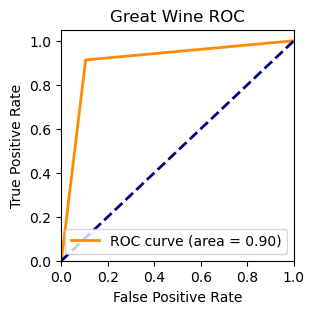

<Figure size 1000x2000 with 0 Axes>

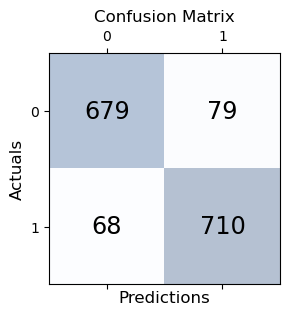

In [103]:


train_X, test_X, train_y, test_y=train_test_split(scaled_df,labels,train_size=0.8, test_size=0.2)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#precision: 0.7947310647639956
#recall:  0.9427083333333334
#accuracy:  0.849609375
#clf = KNeighborsClassifier()

# precision: 0.7745664739884393
# recall:  0.871261378413524
# accuracy:  0.80859375
#clf = SVC()

#precision: 0.9171817058096415
#recall:  0.935687263556116
#accuracy:  0.9231770833333334
clf = RandomForestClassifier()

#precision: 0.8066666666666666
#recall:  0.4647887323943662
#accuracy:  0.6712239583333334
#clf = Perceptron()

#precision: 0.8479087452471483
#recall:  0.87109375
#accuracy:  0.857421875
#clf = DecisionTreeClassifier()

#precision: 0.7860576923076923
#recall:  0.8460543337645536
#accuracy:  0.806640625
#clf = AdaBoostClassifier()

#precision: 0.9070385126162018
#recall:  0.893979057591623
#accuracy:  0.9016927083333334
#clf = BaggingClassifier()

#precision: 0.8046116504854369
#recall:  0.8816489361702128
#accuracy:  0.8372395833333334
#clf = GradientBoostingClassifier()

clf.fit(train_X, train_y)
yhat = clf.predict(test_X)

# metrics
print('precision:', precision_score(test_y, yhat))
print('recall: ', recall_score(test_y, yhat))
print('accuracy: ', accuracy_score(test_y, yhat))
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
roc_plot = plot_roc(roc_auc)
roc_plot.show()

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
mat = plot_conf_mat(conf_matrix)
mat.show()